In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import os
from platform import python_version
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

print(f"Tensorflow Version: {tf.__version__}")
import keras
print(f"Keras Version: {keras.__version__}")

Tensorflow Version: 2.16.1
Keras Version: 3.3.3


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth and limit memory usage
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])  # Memory limit in MB
    except RuntimeError as e:
        print(e)

# Now you can create your session or model
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto())



seed = random.randint(0, 1000)
# seed=212
# Set random seeds
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"SEED: {seed}")

SEED: 479


In [3]:
epochs = 150
batch_size = 48
testsplit = .3
img_size= 228
learning_rate = 0.0001

targetx = img_size
targety = img_size

data_dir = "/kaggle/input/coconut-tree-disease-dataset/Coconut Tree Disease Dataset/"

In [4]:
def custom_preprocessing(image):
    return image / 255.0

train_datagen = ImageDataGenerator(
        preprocessing_function=custom_preprocessing,
        validation_split=testsplit
)

test_datagen = ImageDataGenerator(
        preprocessing_function=custom_preprocessing
)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
       
)
test_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation",
)


Found 4061 images belonging to 5 classes.
Found 1737 images belonging to 5 classes.


In [5]:
train_generator.class_indices

{'Bud Root Dropping': 0,
 'Bud Rot': 1,
 'Gray Leaf Spot': 2,
 'Leaf Rot': 3,
 'Stem Bleeding': 4}

In [6]:
target_names=list(train_generator.class_indices.keys())
classes = len(target_names)
target_names

['Bud Root Dropping', 'Bud Rot', 'Gray Leaf Spot', 'Leaf Rot', 'Stem Bleeding']

/kaggle/input/coconut-tree-disease-dataset/Coconut Tree Disease Dataset/Leaf Rot/LeafRot944.jpg


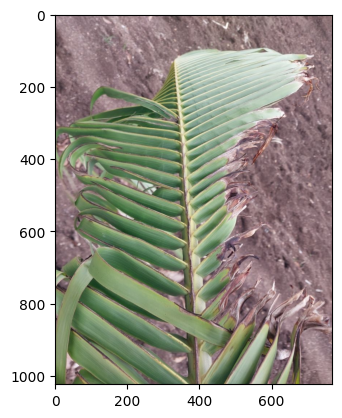

In [7]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [8]:
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False)


earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=25,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

In [9]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

In [10]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 228, 228,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 114, 114,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 114, 114,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 114, 114,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 114, 114,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 114, 114,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 114, 114,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 114, 114,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 114, 114,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 114, 114,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 114, 114,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 114, 114,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 115, 115,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 57, 57,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 57, 57,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 57, 57,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 57, 57,    │      2,304 │ block_1_depthwis

 Total params: 3,087,429 (11.78 MB)

 Trainable params: 3,048,965 (11.63 MB)

 Non-trainable params: 38,464 (150.25 KB)

In [11]:
%%time

model_history = model.fit(train_generator, 
                                validation_data=test_generator, 
                                epochs=epochs,
                                callbacks=[reducelr, earlystop,checkpoint])

Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4616 - loss: 6.6215
Epoch 1: val_accuracy improved from -inf to 0.74899, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 658s 7s/step - accuracy: 0.4636 - loss: 6.6169 - val_accuracy: 0.7490 - val_loss: 3.9231 - learning_rate: 1.0000e-04
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8688 - loss: 5.1713
Epoch 2: val_accuracy improved from 0.74899 to 0.78238, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 610s 7s/step - accuracy: 0.8691 - loss: 5.1679 - val_accuracy: 0.7824 - val_loss: 3.7313 - learning_rate: 1.0000e-04
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9418 - loss: 4.1929
Epoch 3: val_accuracy improved from 0.78238 to 0.80656, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 603s 7s/step - accuracy: 0.9419 - loss: 4.1911 - val_accuracy: 0.8066 - val_loss: 3.1249 - learning_rate: 1.0000e-04
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - 

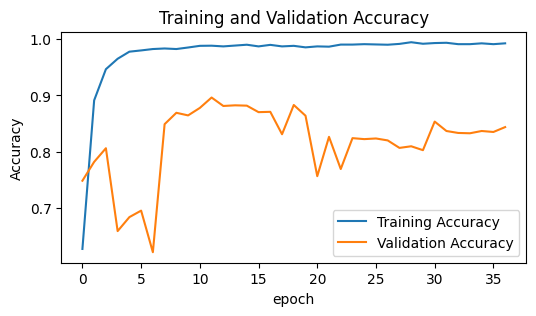

In [12]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

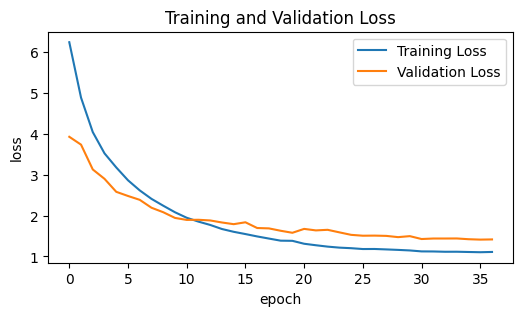

In [13]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [14]:
predictions = model.predict(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step
Classification Report
                   precision    recall  f1-score   support

Bud Root Dropping       0.92      1.00      0.96       154
          Bud Rot       0.96      0.90      0.93       141
   Gray Leaf Spot       0.81      0.97      0.88       640
         Leaf Rot       0.99      0.70      0.82       501
    Stem Bleeding       0.96      1.00      0.98       301

         accuracy                           0.90      1737
        macro avg       0.93      0.92      0.91      1737
     weighted avg       0.91      0.90      0.89      1737



In [15]:
#confusion matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=test_generator.classes


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

37/37 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step


array([[154,   0,   0,   0,   0],
       [ 12, 127,   0,   2,   0],
       [  0,   4, 622,   1,  13],
       [  2,   1, 144, 353,   1],
       [  0,   0,   0,   0, 301]])

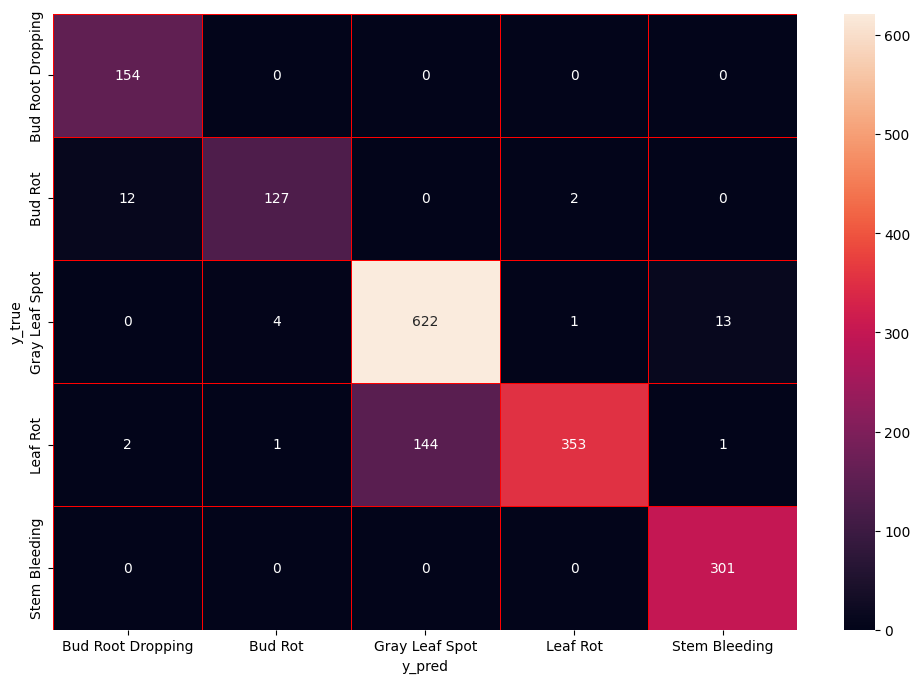

In [16]:
f, ax=plt.subplots(figsize=(12,8))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax,xticklabels=target_names, yticklabels=target_names,)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig('confusion_matrix.png', transparent=False, dpi=500)
plt.show()

In [17]:
model.evaluate(test_generator , verbose = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9241 - loss: 1.9427


[1.8956797122955322, 0.8963730335235596]